<h1 style="color:orange"> <b> Embedding Techniques Comparison </b> </h1>

In this notebook I will compare different word embedding techniques :<br>
- <b> Non-semantic Embedding: </b> Count Based <br> 
  - Bag of words - simple method <br>
  - tf-idf - statistical <br>
- <b> Semantic Embedding: </b> <br>
  - Context Free: <br>
    - word2vec - statistical + deep learning(neural networks) <br>
    - glove<br>
    - FastText <br>
  - Contextual: Pre-trained MTEB Embedding Layers  <br>
    - EMLo<br>
    - bert<br>

<h1 style="color:Gray"> <b> The  difference between Non-semantic Embeddings and Semantic Embeddings:  </b> </h1>

* <b> Non-semantic embeddings are useful for tasks that rely on </b> understanding local word relationships and syntactic patterns. 
* <b> Context-free semantic embeddings </b>, on the other hand, are valuable for applications that require a <b> more explicit representation of word meaning and semantic relationships </b>, such as information retrieval, question answering, or machine translation.
* <b style="color:red"> Non-semantic embeddings are depreacated and no longer used. </b>

<h1 style="color:red"> <b> Comparison of Context-Free semantic embeddings:  </b> </h1> 

* Word2Vec
* Glove
* FastText

In [3]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
%matplotlib inline
import gensim.models.keyedvectors as word2vec
import gc

In [4]:
train = pd.read_csv('/kaggle/input/testandtraindata/train.csv')
test = pd.read_csv('/kaggle/input/testandtraindata/test.csv')
embed_size=0

In [5]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [6]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [7]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

There's no use in comparing non-pretrained models with pre-trained ones as it's <b> obvious that pretrained models give a better accuracy </b> :
* I will pretrain GLOVE embeddings based on Twitter text.
* I will pretrain Word2Vec embeddings Google Negative News text corpus

# Load Embedding Matrix :
The function would return a new embedding matrix that has the loaded weights from the pretrained embeddings for the common words we have, and randomly initialized numbers that has the same mean and standard deviation for the rest of the weights in this matrix.

In [ ]:
def loadEmbeddingMatrix(typeToLoad):
        if(typeToLoad=="glove"):
            EMBEDDING_FILE='../input/glove-twitter/glove.twitter.27B.25d.txt'
            embed_size = 25
        elif(typeToLoad=="word2vec"):
            word2vecDict = word2vec.KeyedVectors.load_word2vec_format("../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin", binary=True)
            embed_size = 300
        elif(typeToLoad=="fasttext"):
            EMBEDDING_FILE='../input/fasttext/wiki.simple.vec'
            embed_size = 300

        if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
            embeddings_index = dict()
            #Transfer the embedding weights into a dictionary by iterating through every line of the file.
            f = open(EMBEDDING_FILE)
            for line in f:
                #split up line into an indexed array
                values = line.split()
                #first index is word
                word = values[0]
                #store the rest of the values in the array as a new array
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs #50 dimensions
            f.close()
            print('Loaded %s word vectors.' % len(embeddings_index))
        else:
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix


In [9]:
embedding_matrix = loadEmbeddingMatrix('word2vec')
embedding_matrix.shape

Loaded 3000000 word vectors.
total embedded: 66078 common words


In [12]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dense(50, activation="relu")(x)
x = Dense(6, activation="sigmoid")(x)

In [19]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 300)          63101100  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 120)          173280    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

In [ ]:
batch_size = 32
epochs = 4
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# Comparisons

In [49]:
loadEmbeddingMatrix('word2vec')

Loaded 3000000 word vectors.
total embedded: 66078 common words


array([[ 0.08007812,  0.10498047,  0.04980469, ...,  0.00366211,
         0.04760742, -0.06884766],
       [-0.08142847, -0.20384073, -0.15534663, ...,  0.04686864,
        -0.09127439,  0.01445492],
       [-0.25383709, -0.09373858,  0.1457161 , ..., -0.05272888,
        -0.10990721, -0.11065085],
       ..., 
       [-0.00726541,  0.03376685, -0.20983193, ...,  0.07422345,
         0.08893473, -0.28731358],
       [ 0.25585938,  0.13085938,  0.13574219, ...,  0.15136719,
         0.13085938, -0.36523438],
       [-0.02987144,  0.06870021, -0.09235254, ...,  0.00992181,
         0.08548394, -0.12957195]])

In [ ]:
loadEmbeddingMatrix('glove') #for GLOVE or
loadEmbeddingMatrix('fasttext') #for fasttext

In [33]:
all_losses = {
'word2vec_loss': [0.084318213647104789,
  0.057314205012433353,
  0.051338302593577821,
  0.047672802178572039],
 'word2vec_val_loss': [0.063002561892695971,
  0.057253835496480658,
  0.051085027624451551,
  0.049801279793734249],
'glove_loss': [0.11598931579683543,
  0.088738223480436862,
  0.079895263566000005,
  0.075343037429358703],
 'glove_val_loss': [0.093467933030432285,
  0.080007083813922117,
  0.075349041991106688,
  0.072366507668134517],
 'fasttext_loss': [0.079714499498945865,
  0.056074704045674786,
  0.050703874653286324,
  0.047420131195761134],
 'fasttext_val_loss': [0.058888281775148932,
  0.054906051694414926,
  0.054768857866843601,
  0.050697043558286421]
}

# Comparing Loss Functions :
* The loss represents how well the model is able to predict the context or neighboring words given a target word.
* "val-loss" stands for validation loss and is used to evaluate the model's performance on unseen data and to monitor its generalization ability

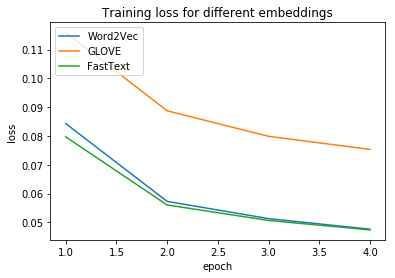

In [34]:
#f, ax = plt.subplots(1)
epochRange = np.arange(1,5,1)
plt.plot(epochRange,all_losses['word2vec_loss'])
plt.plot(epochRange,all_losses['glove_loss'])
plt.plot(epochRange,all_losses['fasttext_loss'])
plt.title('Training loss for different embeddings')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Word2Vec', 'GLOVE','FastText'], loc='upper left')
plt.show()

# Plotting the loss and Validation loss over training iterations :
* By observing the loss and validation loss curves, you can gain insights into the model's convergence, stability, and potential issues such as overfitting or underfitting.
* The loss should gradually decrease as the model learns to capture meaningful word representations. The validation loss should follow a similar trend, indicating that the model is not only optimizing for the training data but also generalizing well to unseen data. 


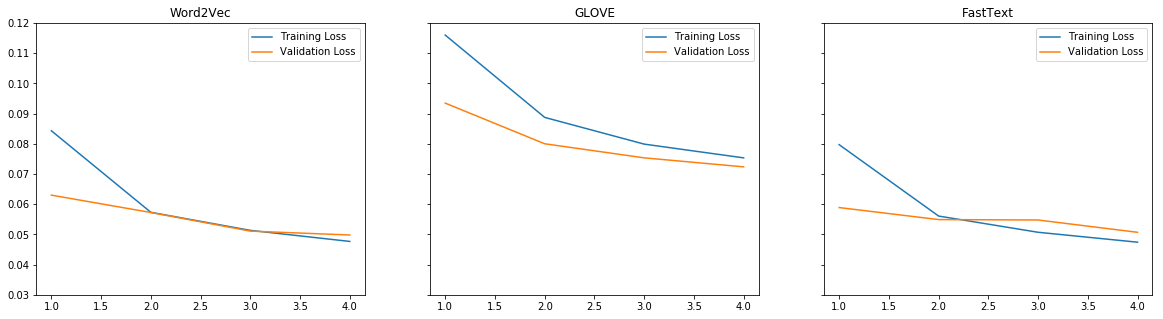

In [51]:
import matplotlib.pyplot as plt

fig, (ax2, ax3, ax4) = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(20, 5))

ax2.plot(epochRange, all_losses['word2vec_loss'], label='Training Loss')
ax2.plot(epochRange, all_losses['word2vec_val_loss'], label='Validation Loss')
ax2.set_title('Word2Vec')
ax2.set_ylim(0.03, 0.12)
ax2.legend()

ax3.plot(epochRange, all_losses['glove_loss'], label='Training Loss')
ax3.plot(epochRange, all_losses['glove_val_loss'], label='Validation Loss')
ax3.set_title('GLOVE')
ax3.set_ylim(0.03, 0.12)
ax3.legend()

ax4.plot(epochRange, all_losses['fasttext_loss'], label='Training Loss')
ax4.plot(epochRange, all_losses['fasttext_val_loss'], label='Validation Loss')
ax4.set_title('FastText')
ax4.set_ylim(0.03, 0.12)
ax4.legend()

plt.show()


In [46]:
wordCount = {'word2vec':66078,'glove':81610,'fasttext':59613}

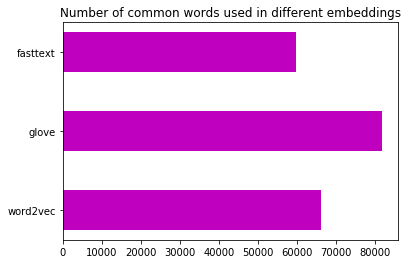

In [48]:
ind = np.arange(0,3,1)  # the x locations for the groups
width = 0.35       # the width of the bars

plt.title('Number of common words used in different embeddings')
embNames = list(wordCount.keys())
embVals = list(wordCount.values())
plt.barh(ind,embVals,align='center', height=0.5, color='m',tick_label=embNames)
plt.show()

# Comparing average validation loss: 
* To determine which model performs the best based on the provided loss values, we can compare the validation losses for each model.
* Lower validation losses indicate better performance, as they represent how well the models generalize to unseen data.

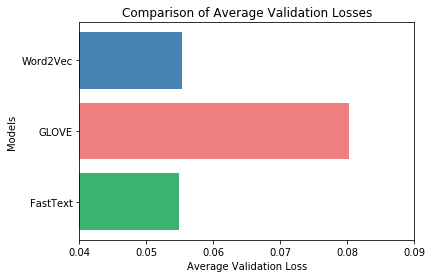

In [56]:
all_losses = {
    'word2vec_loss': [0.084318213647104789, 0.057314205012433353, 0.051338302593577821, 0.047672802178572039],
    'word2vec_val_loss': [0.063002561892695971, 0.057253835496480658, 0.051085027624451551, 0.049801279793734249],
    'glove_loss': [0.11598931579683543, 0.088738223480436862, 0.079895263566000005, 0.075343037429358703],
    'glove_val_loss': [0.093467933030432285, 0.080007083813922117, 0.075349041991106688, 0.072366507668134517],
    'fasttext_loss': [0.079714499498945865, 0.056074704045674786, 0.050703874653286324, 0.047420131195761134],
    'fasttext_val_loss': [0.058888281775148932, 0.054906051694414926, 0.054768857866843601, 0.050697043558286421]
}

models = ['Word2Vec', 'GLOVE', 'FastText']
avg_val_losses = [
    np.mean(all_losses['word2vec_val_loss']),
    np.mean(all_losses['glove_val_loss']),
    np.mean(all_losses['fasttext_val_loss'])
]

colors = ['steelblue', 'lightcoral', 'mediumseagreen']

plt.barh(models, avg_val_losses, color=colors)
plt.xlabel('Average Validation Loss')
plt.ylabel('Models')
plt.title('Comparison of Average Validation Losses')

plt.xlim(0.04, 0.085)
plt.xticks(np.arange(0.04, 0.10, 0.01))

plt.show()


# Semantic Vs Syntactic Analogies: 
* Syntactic analogies focus on the grammatical or structural aspects of language
* Semantic analogies focus on the meaning and semantic relationships between words. 
* Syntactic analogies deal with surface-level transformations, while semantic analogies capture deeper semantic associations and relatedness.
# Comparison: 
* Comparing the average validation losses, we can see that FastText has the lowest average validation loss of 0.05406555872367397. 
* WordRank performs better for Semantic Analogies 
* FastText performs better for Syntactic Analogies (the use of n-grams). 
# Conclusion :
<b style="color:red"> Disadvantages of Non-Contextual Semantic Models : </b> 
* We have to manually pre-train them on datasets
* Conflict between Semantic and Syntactic Analogies
* Are not task-oriented
* They don't take into consideration the overall context. <br>
<b style="color:green">==> It's better to use the contextual semantic embedding layers of pre-trained models. </b>




<h1 style="color:green"> <b> Comparing Sentence Transformers: </b> </h1>
As we are focusing on information Retrieval we will be comparing models that focus on the <b> Retrieval Task </b> from MTEB (Massive Text Embedding Benchmark) models in The Hugging Face Documentation's LeaderBoard. <br>
<b> The used Metric:</b> Normalized Discounted Cumulative Gain @ k (ndcg_at_10)

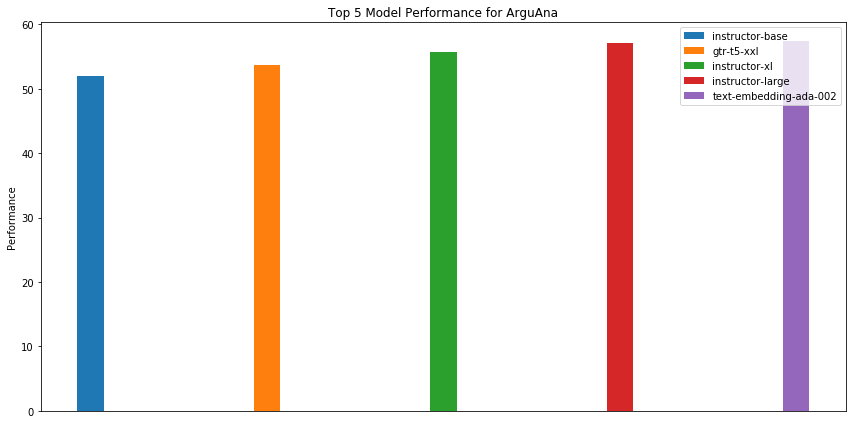

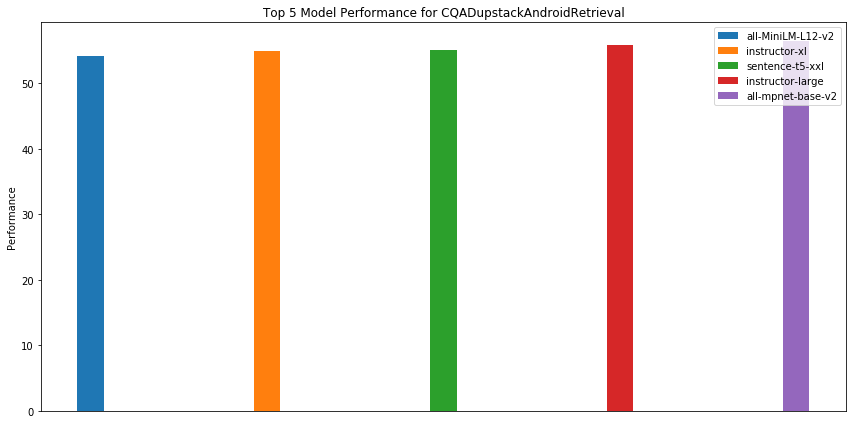

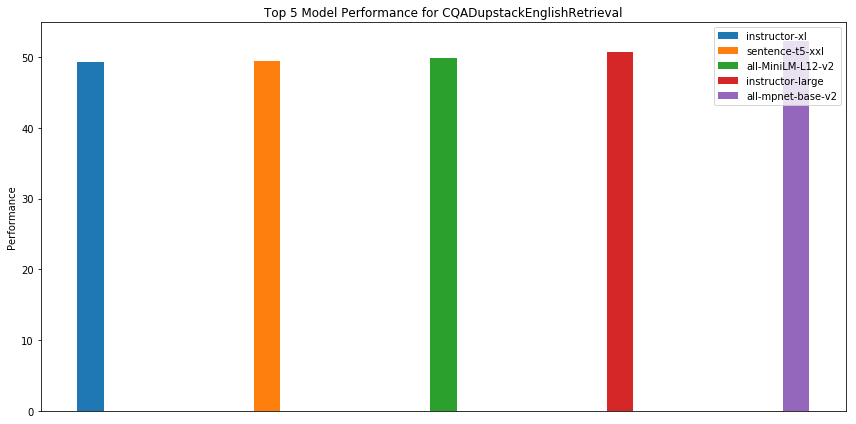

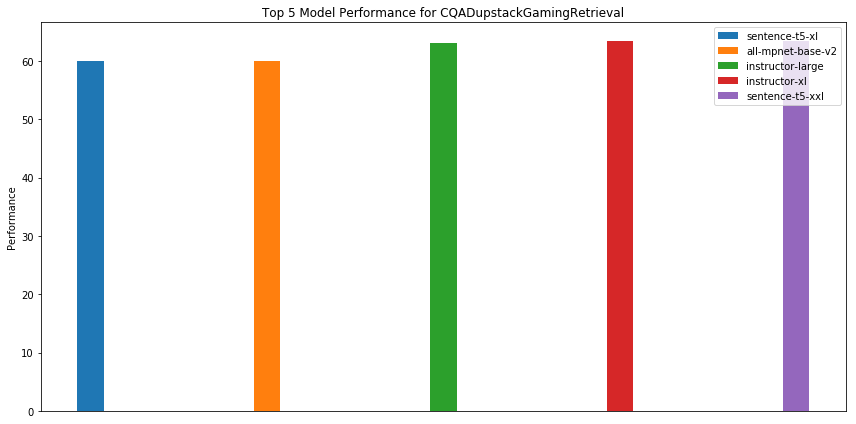

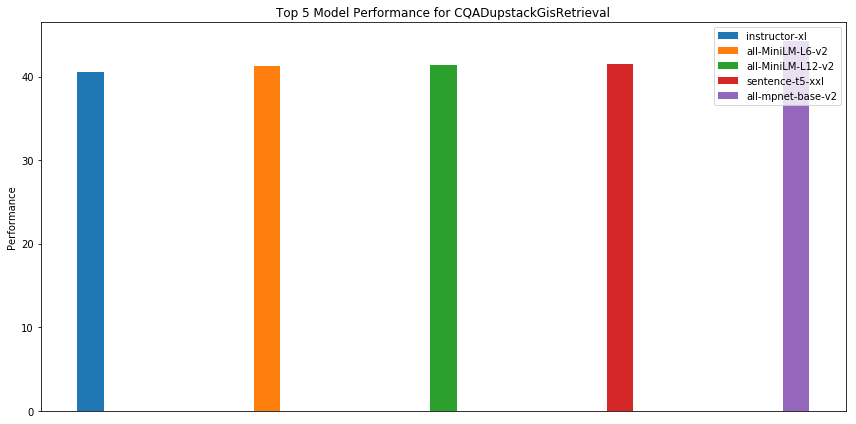

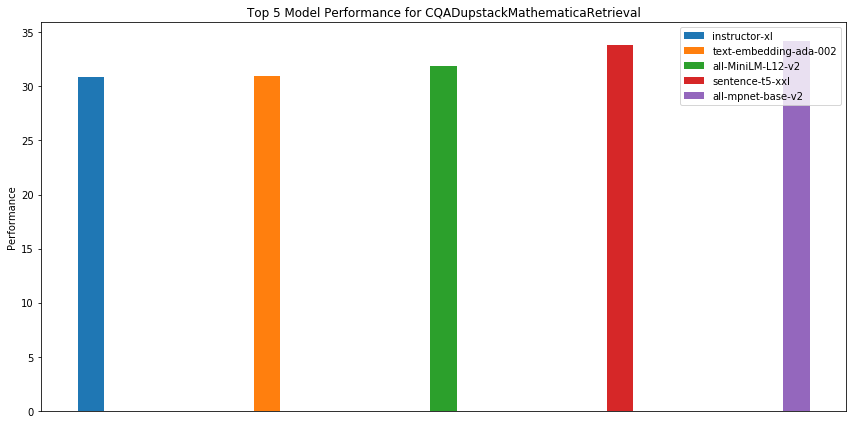

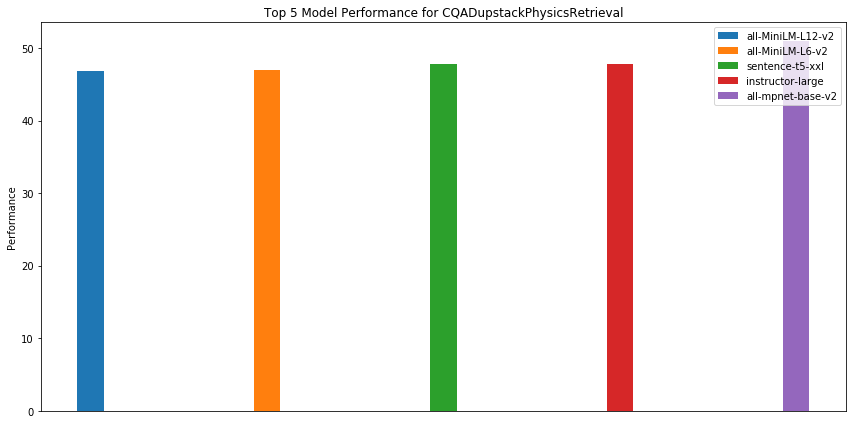

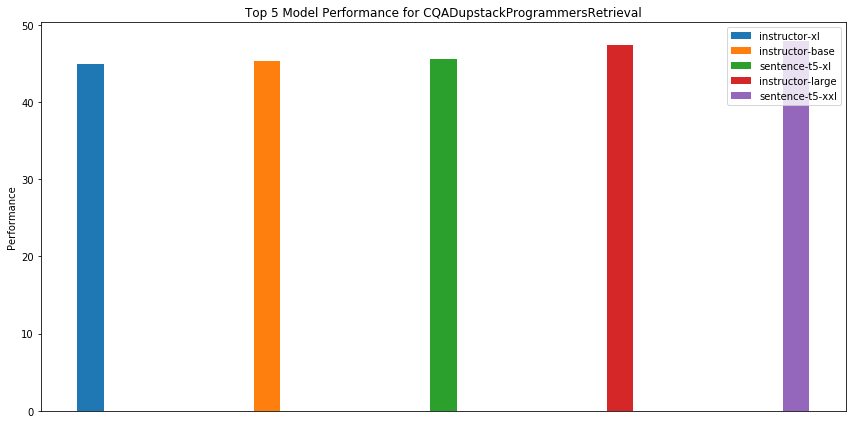

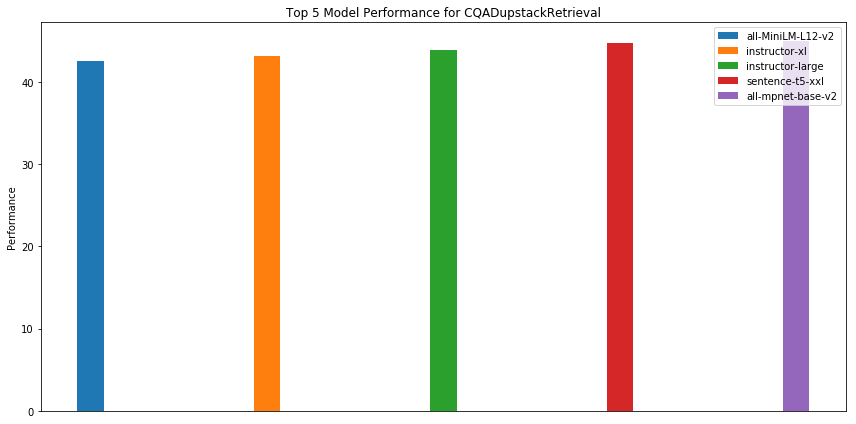

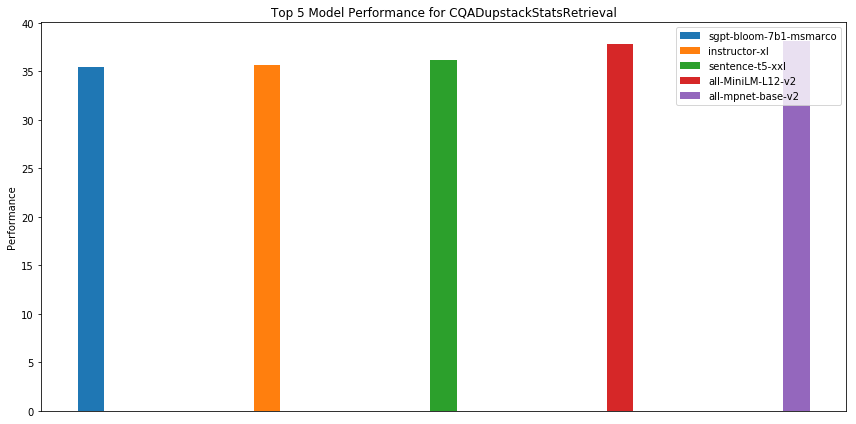

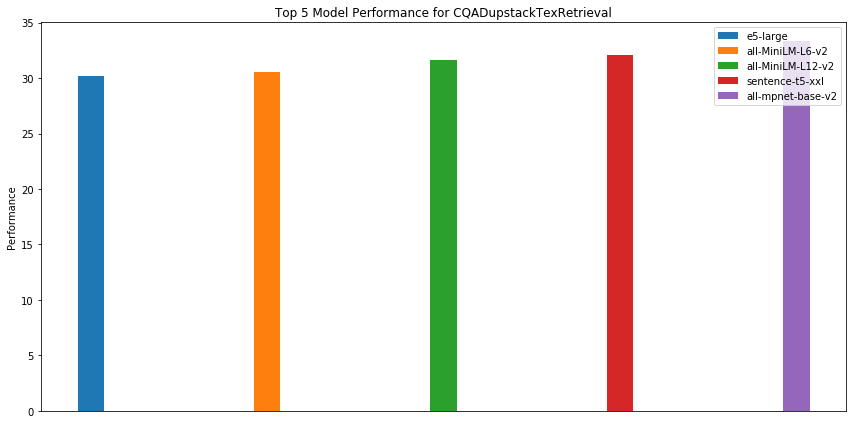

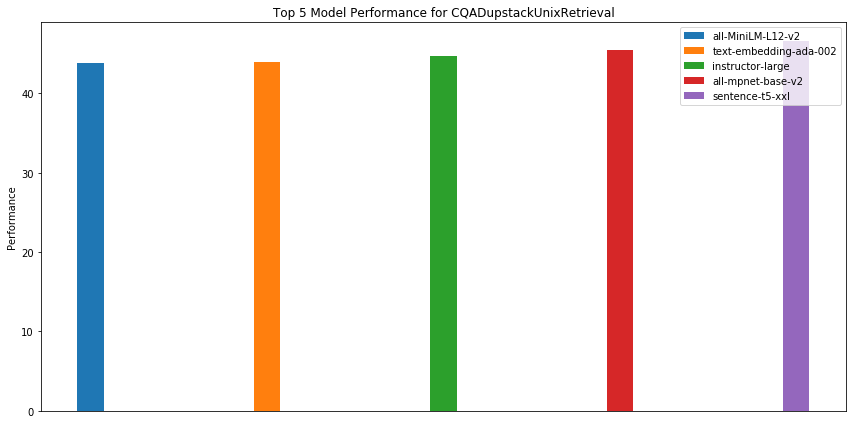

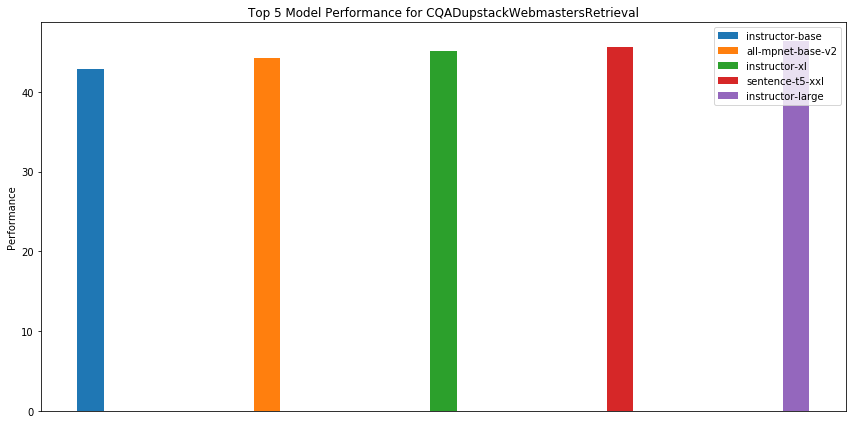

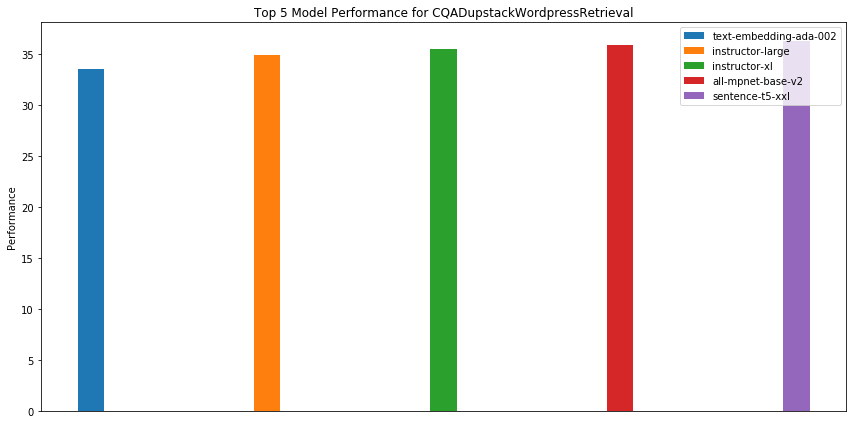

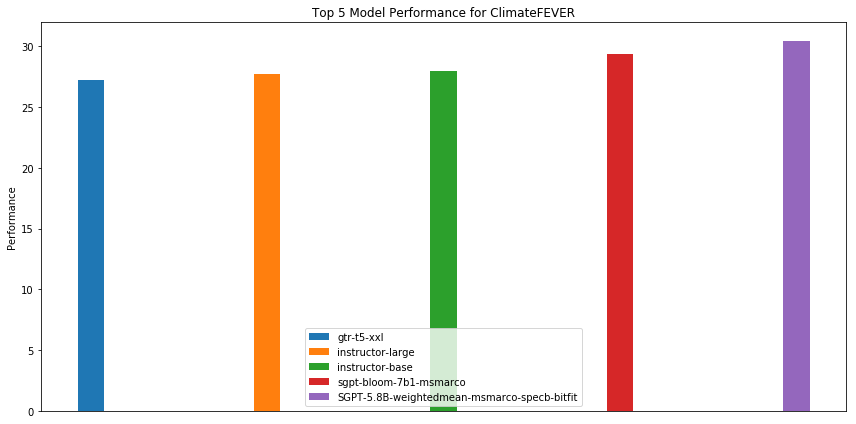

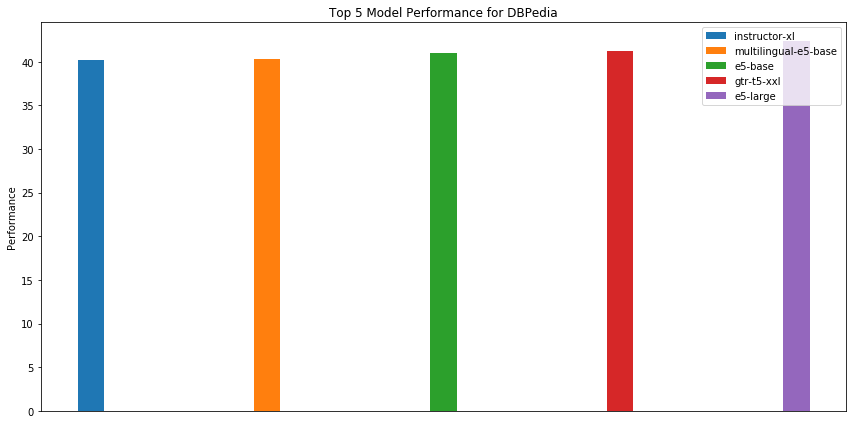

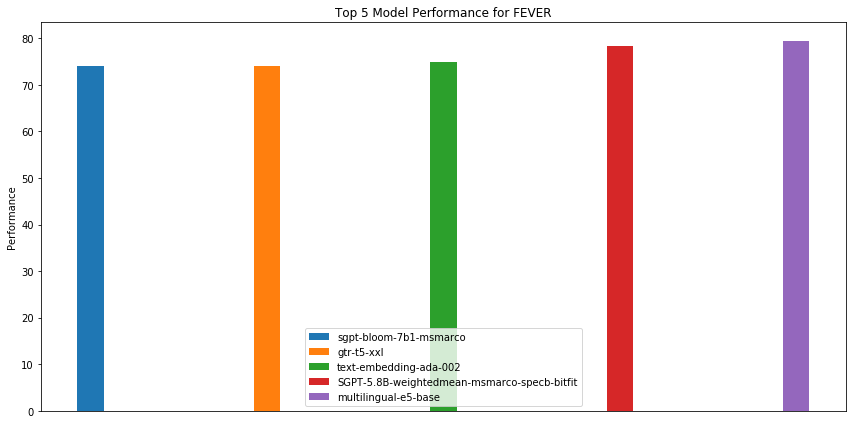

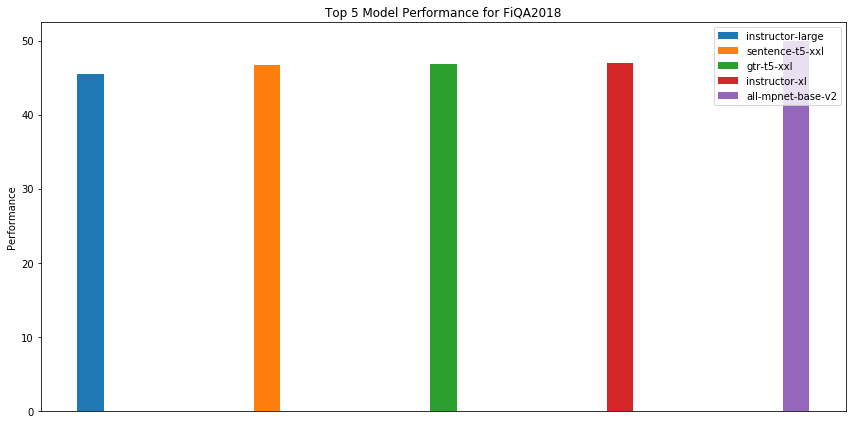

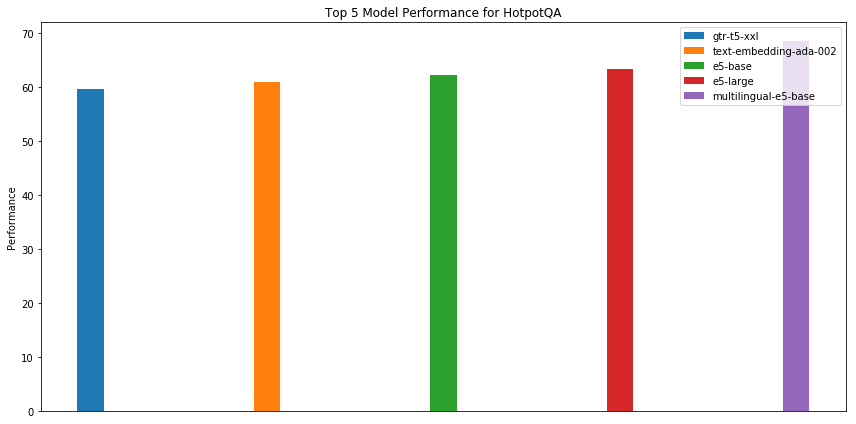

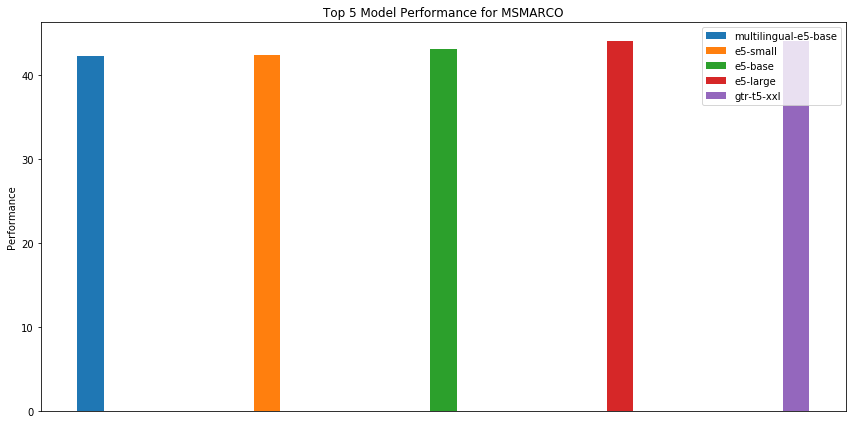

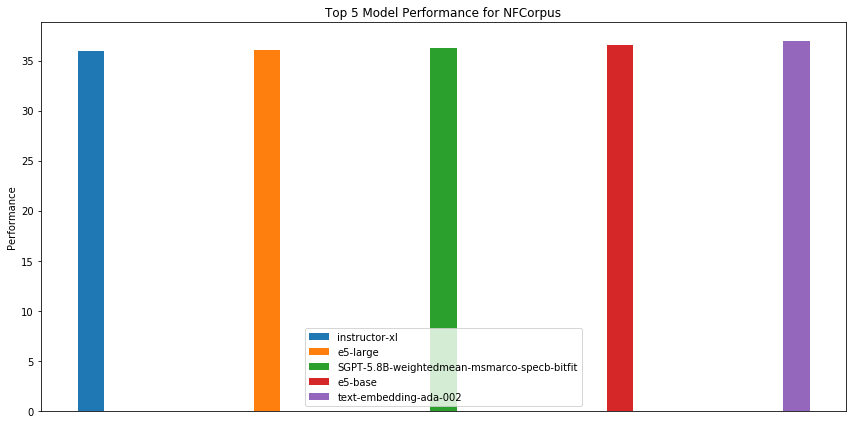

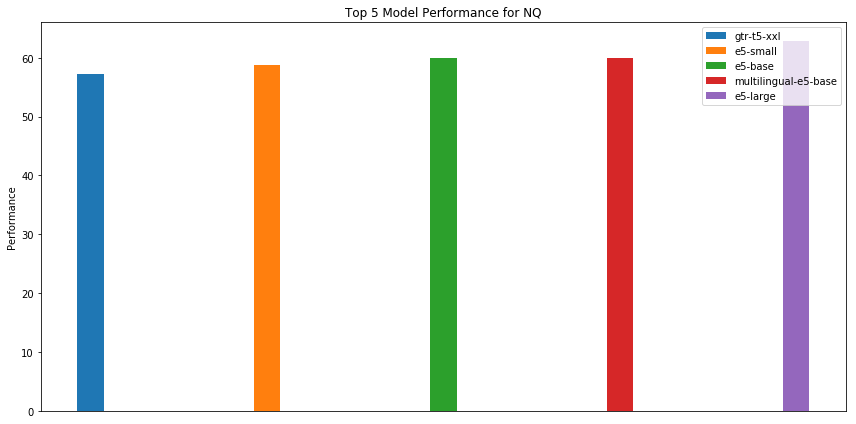

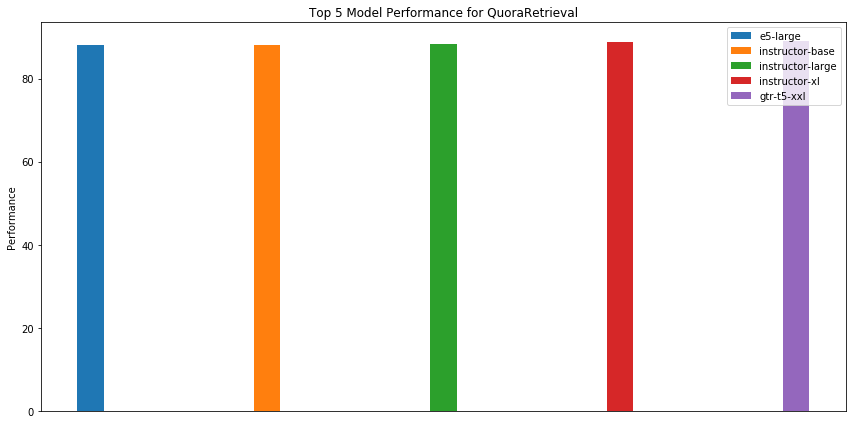

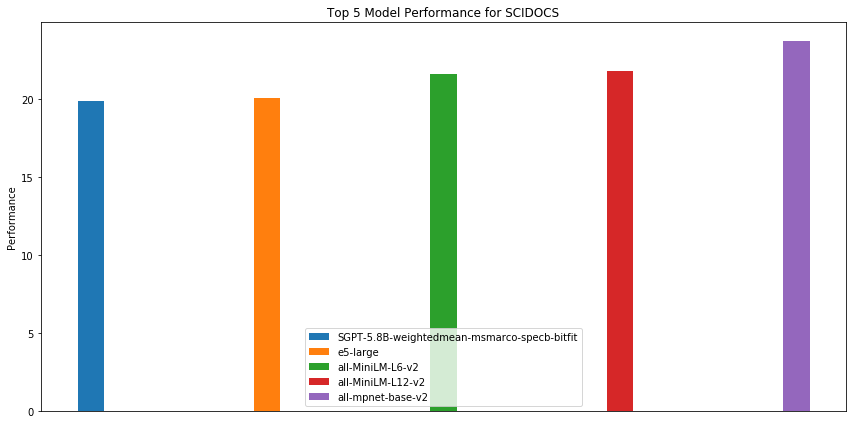

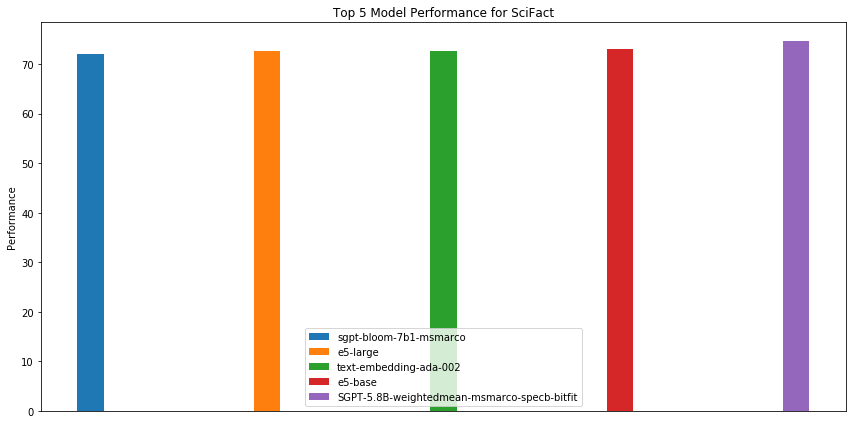

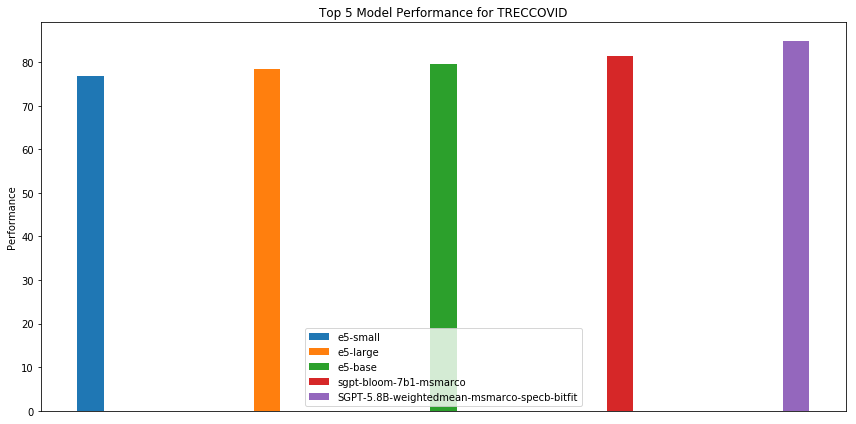

IndexError: list index out of range

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Define the models and tests
models = [
    "all-mpnet-base-v2",
    "sentence-t5-xxl",
    "all-MiniLM-L12-v2",
    "all-MiniLM-L6-v2",
    "e5-large",
    "instructor-large",
    "text-embedding-ada-002",
    "e5-base",
    "instructor-xl",
    "sgpt-bloom-7b1-msmarco",
    "instructor-base",
    "sentence-t5-xl",
    "multilingual-e5-base",
    "gtr-t5-xxl",
    "SGPT-5.8B-weightedmean-msmarco-specb-bitfit",
    "e5-small"
]

tests = [
    "ArguAna",
    "CQADupstackAndroidRetrieval",
    "CQADupstackEnglishRetrieval",
    "CQADupstackGamingRetrieval",
    "CQADupstackGisRetrieval",
    "CQADupstackMathematicaRetrieval",
    "CQADupstackPhysicsRetrieval",
    "CQADupstackProgrammersRetrieval",
    "CQADupstackRetrieval",
    "CQADupstackStatsRetrieval",
    "CQADupstackTexRetrieval",
    "CQADupstackUnixRetrieval",
    "CQADupstackWebmastersRetrieval",
    "CQADupstackWordpressRetrieval",
    "ClimateFEVER",
    "DBPedia",
    "FEVER",
    "FiQA2018",
    "HotpotQA",
    "MSMARCO",
    "NFCorpus",
    "NQ",
    "QuoraRetrieval",
    "SCIDOCS",
    "SciFact",
    "TRECCOVID",
    "Touche2020"
]

# Define the performance scores
performance_scores = np.array([
    [46.52, 56.49, 52.29, 60.03, 44.27, 34.21, 50.97, 44.17, 44.96, 38.15, 33.35, 45.41, 44.24, 35.94, 21.97, 32.09, 50.86, 49.96, 39.29, 39.75, 33.29, 50.45, 87.46, 23.76, 65.57, 51.33, 19.93],
    [39.85, 55.07, 49.42, 63.46, 41.55, 33.79, 47.72, 47.93, 44.65, 36.23, 32.1, 46.61, 45.67, 36.31, 14.63, 39.19, 51.2, 46.68, 42.14, 27.67, 35.08, 52.87, 85.96, 17.17, 55.38, 59.48, 21.65],
    [47.13, 54.12, 49.85, 56.86, 41.41, 31.86, 46.81, 41.33, 42.53, 37.82, 31.66, 43.86, 41.38, 33.46, 21.57, 33.35, 55.9, 37.27, 44.59, 39.03, 32.25, 46.47, 87.75, 21.82, 62.64, 50.82, 17.22],
    [50.17, 53.83, 47.78, 56.92, 41.31, 29.29, 46.98, 38.97, 41.32, 35.38, 30.52, 41.31, 40.47, 33.15, 20.27, 32.33, 51.93, 36.87, 46.51, 36.54, 31.59, 43.87, 87.56, 21.64, 64.51, 47.25, 16.9],
    [49.35, 46.85, 47.18, 57.41, 36.97, 28.95, 43.5, 39.97, 39.44, 33.36, 30.15, 38.57, 37.96, 32.45, 22.4, 42.39, 65.03, 38.56, 63.33, 44.05, 36.07, 62.86, 88.18, 20.12, 72.58, 78.32, 27.21],
    [57.05, 55.9, 50.77, 63.07, 39.51, 30.66, 47.82, 47.45, 43.82, 34.62, 30.03, 44.68, 46.39, 34.91, 27.74, 36.68, 72.69, 45.45, 55.18, 39.65, 34.09, 50.1, 88.44, 18.55, 64.43, 58.06, 21.56],
    [57.44, 51.26, 49.26, 59.25, 39.84, 30.92, 45.18, 43.44, 41.69, 33.91, 29.97, 43.99, 39.71, 33.57, 21.64, 39.39, 74.99, 44.41, 60.9, 40.91, 36.97, 51.58, 87.6, 18.36, 72.75, 68.47, 21.61],
    [51.41, 45.61, 45.72, 55.03, 37.28, 28.26, 42.91, 40.82, 38.92, 33.73, 29.68, 38.31, 36.52, 33.18, 15.38, 41.02, 58.24, 36.37, 62.21, 43.14, 36.59, 59.97, 87.92, 18.99, 73.08, 79.64, 28.31],
    [55.65, 54.99, 49.32, 63.36, 40.58, 30.84, 45.28, 44.9, 43.09, 35.65, 29.09, 42.52, 45.14, 35.47, 26.54, 40.24, 70.03, 46.96, 55.88, 41.61, 36, 57.24, 88.85, 17.36, 64.56, 71.4, 23.44],
    [47.28, 47.68, 46.29, 56.68, 37.04, 26.48, 45.61, 40.53, 39.62, 35.44, 28.23, 38.41, 40.85, 32.22, 29.39, 39.03, 73.97, 35.84, 57.26, 41.12, 35.78, 53.15, 74.71, 18.62, 72.11, 81.37, 23.98],
    [52.03, 52.61, 47.18, 58.84, 38.47, 28.28, 44.22, 45.3, 40.95, 33.1, 28.2, 40.36, 42.82, 32.02, 27.95, 33.34, 71.85, 39.18, 54.19, 37.76, 31.59, 45.88, 88.19, 17.09, 57.83, 58.55, 20.37],
    [39.4, 51.12, 44.77, 59.93, 37.32, 30.63, 43.57, 45.58, 40.78, 32.66, 27.69, 41.81, 42.31, 31.93, 10.61, 33.65, 36.12, 44.71, 37.17, 25.17, 33.18, 46.29, 85.85, 15.97, 50.91, 54.77, 22.51],
    [44.23, 47.83, 44.06, 59.2, 34.93, 27.03, 41.58, 40.7, 38.52, 32.59, 27.31, 36.73, 39.21, 31.11, 23.86, 40.36, 79.44, 38.17, 68.56, 42.27, 32.46, 60.02, 87.65, 17.16, 69.35, 69.76, 21.35],
    [53.77, 47.65, 47.9, 57.47, 35.21, 27.25, 41.33, 40.16, 38.56, 32.02, 26.98, 38.35, 37.41, 30.99, 27.21, 41.28, 74.08, 46.78, 59.67, 44.05, 34.18, 57.24, 89.09, 15.88, 66.77, 51.9, 26.76],
    [51.38, 47.67, 46.38, 55.83, 36.95, 28.63, 45.57, 41.48, 39.4, 33.4, 26.81, 38.74, 39.57, 31.82, 30.46, 39.87, 78.24, 37.2, 59.26, 39.91, 36.21, 52.41, 84.58, 19.87, 74.7, 84.88, 25.43],
    [46.69, 45.78, 42.99, 53.31, 33.7, 24.39, 40.54, 36.79, 36.08, 30.9, 26.46, 34.27, 34.98, 28.86, 15.81, 38.64, 53.52, 34.8, 56.34, 42.33, 33.93, 58.73, 87.71, 16.42, 65.6, 76.78]
])

# Set the bar width and spacing
bar_width = 0.15
spacing = 0.8

# Set the x-axis positions for each model
x_positions = np.arange(len(models))

# Iterate over each test and create a bar plot
for test_index, test in enumerate(tests):
    # Get the performance scores for the current test
    test_scores = [scores[test_index] for scores in performance_scores]

    # Sort the scores and select the top 5 indices
    top_indices = np.argsort(test_scores)[-5:]

    # Sort the scores and models based on the top indices
    sorted_scores = [test_scores[i] for i in top_indices]
    sorted_models = [models[i] for i in top_indices]

    # Set the figure size
    plt.figure(figsize=(12, 6))

    # Plot the bars for each model
    for model_index, model_score in enumerate(sorted_scores):
        model_position = x_positions[model_index]
        plt.bar(model_position, model_score, bar_width, label=sorted_models[model_index])

    # Remove x-axis tick labels
    plt.xticks([])

    # Set the y-axis label
    plt.ylabel("Performance")

    # Set the title and legend
    plt.title(f"Top 5 Model Performance for {test}")
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


# Observations :
Through obeservations we notice that throughout diffcerent corpuses, The top 3 models' Embedding Layers are : 
* e5-large
* instructor-xl
* instructor-large

# Conclusion :
* The models give different results based on the corpus they are trained on, Thus we need to test them on our own documents.
* <b> The rest is on a collab notebook. </b> 